In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [ ]:
# ---------- Physical constants / parameters from Table 1 (SI units) ----------
atm = 101325.0            # 1 atm in Pa
S = 72.8e-3               # surface tension (N/m)
rho = 1000.0              # density of water (kg/m^3)
gamma = 5.0/3.0           # adiabatic index for argon
c_sound = 1500.0          # speed of sound in water (m/s)
mu = 1.002e-3             # dynamic viscosity (Pa.s)
P0 = 1.0 * atm            # ambient pressure (Pa)
R0 = 1.0e-6               # ambient (static) radius (m)
h = R0 / 8.86             # van der Waals hard-core radius (m)
# frequency: using 26.5 kHz typical in SBSL literature
f = 26.5e3               # Hz
omega = 2.0 * np.pi * f

In [ ]:
#helper functions for ODE: driving pressure, gas pressure, dp/dt ----------
def P_drive(t, Pa):
    # P(t) = -Pa * cos(omega*t) - trying cosine based on common practice, paper uses -Pa*sin(omega*t)
    return -Pa * np.cos(omega * t)

def p_gas(R):
    # pgas(t) = (P0 + 2S/R0) * ((R0^3 - h^3) / (R^3 - h^3))**gamma
    denom = R**3 - h**3
    denom = np.maximum(denom, 1e-30)
    pref = P0 + 2.0 * S / R0
    return pref * ((R0**3 - h**3) / denom)**gamma

def dpdt(R, Rdot):
    # Equation 7: d/dt pgas = -3 * gamma * pgas * (R^2/(R^3 - h^3)) * Rdot
    denom = R**3 - h**3
    denom = np.maximum(denom, 1e-30)
    pg = p_gas(R)
    return -3.0 * gamma * pg * (R**2 / denom) * Rdot

In [ ]:
# ODE Systems:

def rp_incompressible(t, y, Pa):
    R, Rdot = y
    R=max(R, h*1.0001)
    pg = p_gas(R)
    Pt = P_drive(t, Pa)
    RHS = pg - P0 - Pt - 4.0*mu*Rdot/R - 2.0*S/R
    Rddot = (RHS / rho - 1.5 * Rdot**2) / R
    return [Rdot, Rddot]

def rp_compressible(t, y, Pa):
    # modified Rayleigh-Plesset Eq.(5) from the paper
    R, Rdot = y
    R = max(R, h * 1.0001)
    pg = p_gas(R)
    dpgdt = dpdt(R, Rdot)
    Pt = P_drive(t, Pa)

    # Equation 5 from the paper:
    # R*Rddot * (1 - Rdot/c_sound) + 1.5*Rdot**2 * (1 - 2*Rdot/(3*c_sound)) = (1/rho) * (pg - P0 - Pt - 2*S/R - 4*mu*Rdot/R) + (R/(rho*c_sound))*dpgdt

    # Rearranging to solve for Rddot:
    term1 = (1.0 / rho) * (pg - P0 - Pt - 2.0 * S / R - 4.0 * mu * Rdot / R)
    term2 = (R / (rho * c_sound)) * dpgdt
    lhs_Rddot_coeff = R * (1.0 - Rdot / c_sound)
    lhs_other_terms = 1.5 * Rdot**2 * (1.0 - 2.0 * Rdot / (3.0 * c_sound))

    # Ensure the coefficient for Rddot is not zero or close to zero
    if abs(lhs_Rddot_coeff) < 1e-15:
        Rddot = (term1 + term2 - lhs_other_terms) / 1e-15 * np.sign(lhs_Rddot_coeff)
    else:
        Rddot = (term1 + term2 - lhs_other_terms) / lhs_Rddot_coeff

    return [Rdot, Rddot]

In [ ]:
def simulate(Pa_atm, compressible, t_cycles=1.5, npoints=8000):
    Pa = Pa_atm * atm
    T = 1.0 / f
    t_end = t_cycles * T
    t_eval = np.linspace(0.0, t_end, npoints)
    y0 = [R0, 0.0]
    rhs = lambda t, y: rp_compressible(t, y, Pa) if compressible else rp_incompressible(t, y, Pa)
    sol = solve_ivp(rhs, [0.0, t_end], y0, t_eval=t_eval,
                    rtol=1e-9, atol=1e-12, method='Radau', max_step=1e-7)
    return sol.t, sol.y[0], sol.y[1]

#plotting routines for direct

# def plot_radius(Pa_atm, compressible, t_cycles=1.0):
#     t, R, _ = simulate(Pa_atm, compressible, t_cycles)
#     plt.figure(figsize=(8, 4))
#     plt.plot(t * 1e3, R / R0)
#     plt.xlabel('Time (ms)')
#     plt.ylabel('R / R0')
#     title = 'Modified RP' if compressible else 'Incompressible RP'
#     plt.title(f'{title} — Pa={Pa_atm:.3f} atm')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

def plot_radius(Pa_atm, compressible, t_cycles=1.0):
    t, R, _ = simulate(Pa_atm, compressible, t_cycles)
    plt.figure(figsize=(8, 4))
    plt.plot(t * 1e3, R)
    plt.xlabel('Time (ms)')
    plt.ylabel('R (m)')
    title = 'Modified RP' if compressible else 'Incompressible RP'
    plt.title(f'{title} — Pa={Pa_atm:.3f} atm')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_velocity(Pa_atm, compressible, t_cycles=1.0):
    t, _, Rdot = simulate(Pa_atm, compressible, t_cycles)
    plt.figure(figsize=(8, 4))
    plt.plot(t * 1e3, Rdot)
    plt.xlabel('Time (ms)')
    plt.ylabel('Wall velocity (m/s)')
    title = 'Modified RP' if compressible else 'Incompressible RP'
    plt.title(f'Wall velocity — {title} — Pa={Pa_atm:.3f} atm')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

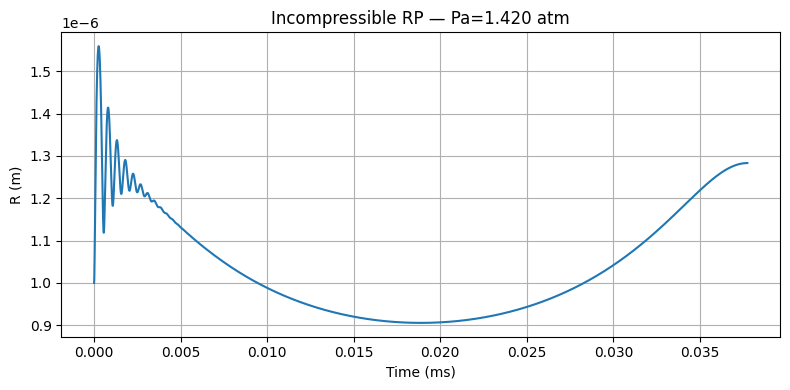

The peak radius is: 1.559e-06 m


In [ ]:
# Fig 1: Incompressible RP, Pa=1.42 atm, 1 cycle
t, R, _ = simulate(Pa_atm=1.42, compressible=False, t_cycles=1.0)
plot_radius(Pa_atm=1.42, compressible=False, t_cycles=1.0)
peak_radius = np.max(R)
print(f"The peak radius is: {peak_radius:.3e} m")

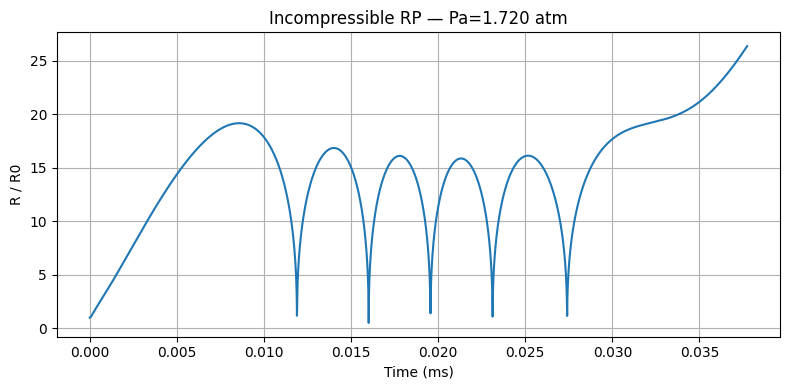

In [ ]:
# Fig 1: Incompressible RP, Pa=1.42 atm, 1 cycle
plot_radius(Pa_atm=1.72, compressible=False, t_cycles=1.0)

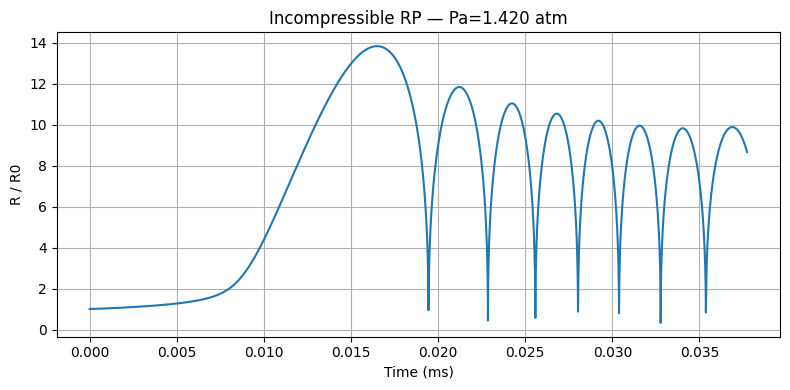

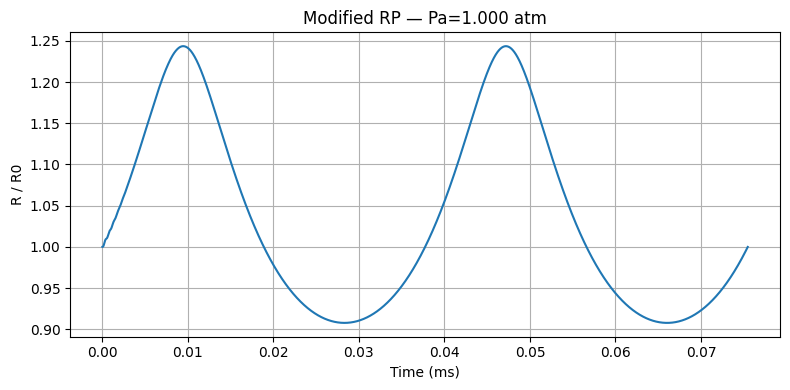

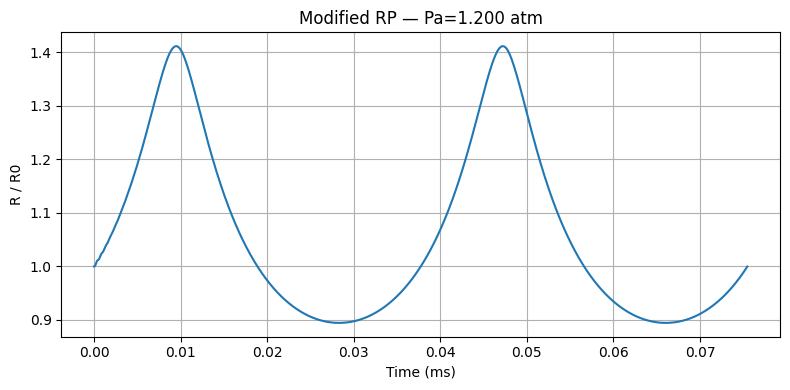

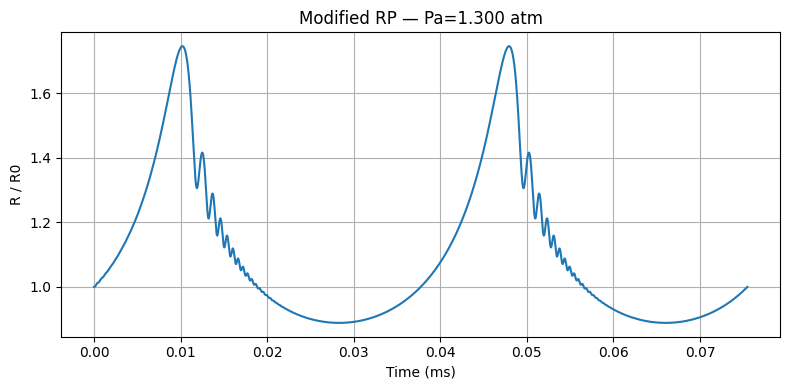

KeyboardInterrupt: 

In [ ]:
# Fig 2: Compressible (modified RP), several Pa, 2 cycles
for Pa in [1.00, 1.20, 1.30, 1.35, 1.40]:
    plot_radius(Pa_atm=Pa, compressible=True, t_cycles=2.0)

# Fig 3: Wall velocity, compressible, same Pa as Fig 2, 2 cycles
for Pa in [1.00, 1.20, 1.30, 1.35, 1.40]:
    plot_velocity(Pa_atm=Pa, compressible=True, t_cycles=2.0)

# Fig 4: Compressible, Pa=1.42 atm, 1 cycle
plot_radius(Pa_atm=1.42, compressible=True, t_cycles=1.0)

# Fig 5: Wall velocity for Fig 4 parameters
plot_velocity(Pa_atm=1.42, compressible=True, t_cycles=1.0)

In [ ]:
# # DONT RUN THIS BLOCK(shown on 08.08.2025)

# def simulate_and_plot_radius(Pa_atm, compressible=True, t_cycles=1.5, show=True):
#     Pa = Pa_atm * atm
#     T = 1.0 / f
#     tmax = t_cycles * T
#     t_eval = np.linspace(0.0, tmax, 8000)

#     y0 = [R0, 0.0]
#     rhs = (lambda t, y: rp_compressible(t, y, Pa)) if compressible else (lambda t, y: rp_incompressible(t, y, Pa))
#     sol = solve_ivp(rhs, [0.0, tmax], y0, t_eval=t_eval,
#                     max_step=1e-5, rtol=1e-7, atol=1e-9)

#     t = sol.t
#     R = sol.y[0]

#     plt.figure(figsize=(8, 4))
#     plt.plot(t*1e3, R)
#     plt.xlabel('Time (ms)')
#     plt.ylabel('R (m)')
#     title = 'Modified RP' if compressible else 'Incompressible RP'
#     plt.title(f'{title} — Pa={Pa_atm:.3f} atm')
#     plt.grid(True)
#     if show:
#         plt.show()

#     return t, R


# def simulate_and_plot_velocity(Pa_atm, compressible=True, t_cycles=1.5, show=True):
#     Pa = Pa_atm * atm
#     T = 1.0 / f
#     tmax = t_cycles * T
#     t_eval = np.linspace(0.0, tmax, 8000)

#     y0 = [R0, 0.0]
#     rhs = (lambda t, y: rp_compressible(t, y, Pa)) if compressible else (lambda t, y: rp_incompressible(t, y, Pa))
#     sol = solve_ivp(rhs, [0.0, tmax], y0, t_eval=t_eval,
#                     max_step=1e-5, rtol=1e-7, atol=1e-9)

#     t = sol.t
#     Rdot = sol.y[1]

#     plt.figure(figsize=(8, 4))
#     plt.plot(t*1e3, Rdot)
#     plt.xlabel('Time (ms)')
#     plt.ylabel('Wall velocity (m/s)')
#     title = 'Modified RP' if compressible else 'Incompressible RP'
#     plt.title(f'Wall velocity — {title} — Pa={Pa_atm:.3f} atm')
#     plt.grid(True)
#     if show:
#         plt.show()

#     return t, Rdot

In [ ]:
t, R, _ = simulate(Pa_atm=1.42, compressible=False, t_cycles=1.0)
peak_radius = np.max(R)
peak_R_R0 = np.max(R / R0)
print(f"R0: {R0:.3e} m")
print(f"Peak R: {peak_radius:.3e} m")
print(f"Peak R/R0: {peak_R_R0:.3f}")

R0: 1.000e-06 m
Peak R: 1.559e-06 m
Peak R/R0: 1.559


# Task
Find the value of `R0` that makes the peak of `R/R0` equal to 18.

## Run simulation with current r0

### Subtask:
Execute the cell to calculate and print the peak R/R0 with the current `R0` value (1e-6).


**Reasoning**:
The subtask is to execute the cell that calculates and prints the peak R/R0 with the current R0 value (1e-6). The cell with ID `305ea1c0` performs this exact task.



In [ ]:
t, R, _ = simulate(Pa_atm=1.42, compressible=False, t_cycles=1.0)
peak_radius = np.max(R)
peak_R_R0 = np.max(R / R0)
print(f"R0: {R0:.3e} m")
print(f"Peak R: {peak_radius:.3e} m")
print(f"Peak R/R0: {peak_R_R0:.3f}")

R0: 1.000e-06 m
Peak R: 1.559e-06 m
Peak R/R0: 1.559


## Analyze result

### Subtask:
Check if the peak R/R0 is close to 18.


**Reasoning**:
Compare the obtained peak R/R0 with the target value and determine if it is close enough.



In [ ]:
target_R_R0 = 18.0
current_peak_R_R0 = peak_R_R0  # Use the variable from the previous execution
tolerance = 0.1 * target_R_R0  # Define a tolerance, e.g., 10%

print(f"Target Peak R/R0: {target_R_R0:.3f}")
print(f"Current Peak R/R0: {current_peak_R_R0:.3f}")
print(f"Tolerance (10% of target): {tolerance:.3f}")

if abs(current_peak_R_R0 - target_R_R0) < tolerance:
    print("The current peak R/R0 is close enough to the target.")
else:
    print("The current peak R/R0 is not close enough to the target.")


Target Peak R/R0: 18.000
Current Peak R/R0: 1.559
Tolerance (10% of target): 1.800
The current peak R/R0 is not close enough to the target.


## Develop search strategy

### Subtask:
Based on the current result, determine how to adjust `R0` to get closer to a peak R/R0 of 18. This might involve increasing or decreasing `R0` and deciding on the step size for the search.


**Reasoning**:
Compare the current peak R/R0 with the target and determine the direction and step size for adjusting R0.



In [ ]:
target_R_R0 = 18.0
current_peak_R_R0 = peak_R_R0

print(f"Target Peak R/R0: {target_R_R0:.3f}")
print(f"Current Peak R/R0: {current_peak_R_R0:.3f}")

if current_peak_R_R0 < target_R_R0:
    adjustment_direction = "increase"
    # Estimate an initial step size. The current value is significantly lower than the target.
    # A simple approach is to use a fraction of the current R0 or the difference.
    # Let's try a step size that is a fraction of the current R0, e.g., 10% of R0.
    initial_step_size = R0 * 0.1
elif current_peak_R_R0 > target_R_R0:
    adjustment_direction = "decrease"
    # If the current value is higher, decrease R0. Use a similar logic for step size.
    initial_step_size = R0 * 0.1
else:
    adjustment_direction = "no change"
    initial_step_size = 0.0

print(f"To get closer to the target, R0 needs to be {adjustment_direction}.")
print(f"Estimated initial step size for R0: {initial_step_size:.3e} m")

Target Peak R/R0: 18.000
Current Peak R/R0: 1.559
To get closer to the target, R0 needs to be increase.
Estimated initial step size for R0: 1.000e-07 m


## Iterate and refine

### Subtask:
Repeatedly run the simulation with adjusted `R0` values, calculate the peak R/R0, and refine the `R0` value until the peak R/R0 is approximately 18.


**Reasoning**:
Implement a loop to iteratively adjust R0, run the simulation, and check the peak R/R0 against the target with a defined tolerance. Print the progress in each iteration.



In [ ]:
target_R_R0 = 18.0
current_R0 = R0  # Start with the initial R0 from the kernel
current_peak_R_R0 = peak_R_R0 # Start with the peak R/R0 from the previous run
tolerance = 1.8 # Absolute tolerance, 10% of 18

print(f"Starting R0: {current_R0:.3e} m, Initial Peak R/R0: {current_peak_R_R0:.3f}")

# Iterative adjustment loop
iteration = 0
max_iterations = 50  # Set a limit to prevent infinite loops
step_size = initial_step_size # Use the estimated initial step size

while abs(current_peak_R_R0 - target_R_R0) > tolerance and iteration < max_iterations:
    iteration += 1

    # Adjust R0
    if current_peak_R_R0 < target_R_R0:
        current_R0 += step_size
        # Consider increasing step_size or using a more sophisticated approach if needed
    else:
        current_R0 -= step_size
        # Consider decreasing step_size or using a more sophisticated approach if needed

    # Update the global R0 before simulation
    R0 = current_R0

    # Run the simulation with the new R0
    try:
        t, R, _ = simulate(Pa_atm=1.42, compressible=False, t_cycles=1.0)
        current_peak_R_R0 = np.max(R / R0)
        print(f"Iteration {iteration}: R0 = {current_R0:.3e} m, Peak R/R0 = {current_peak_R_R0:.3f}")
    except Exception as e:
        print(f"Simulation failed at iteration {iteration} with R0 = {current_R0:.3e}: {e}")
        # Implement a strategy to handle simulation failures, e.g., reduce step size, revert R0
        # For now, we'll just stop
        break


if abs(current_peak_R_R0 - target_R_R0) <= tolerance:
    print(f"\nFound R0 = {current_R0:.3e} m with Peak R/R0 = {current_peak_R_R0:.3f} within tolerance.")
else:
    print(f"\nReached max iterations ({max_iterations}) without finding R0 within tolerance.")
    print(f"Last R0 = {current_R0:.3e} m, Last Peak R/R0 = {current_peak_R_R0:.3f}")


Starting R0: 1.000e-06 m, Initial Peak R/R0: 1.559
Iteration 1: R0 = 1.100e-06 m, Peak R/R0 = 1.660
Iteration 2: R0 = 1.200e-06 m, Peak R/R0 = 1.788
Iteration 3: R0 = 1.300e-06 m, Peak R/R0 = 1.976
Iteration 4: R0 = 1.400e-06 m, Peak R/R0 = 2.496
Iteration 5: R0 = 1.500e-06 m, Peak R/R0 = 6.238
Iteration 6: R0 = 1.600e-06 m, Peak R/R0 = 7.906
Iteration 7: R0 = 1.700e-06 m, Peak R/R0 = 8.570
Iteration 8: R0 = 1.800e-06 m, Peak R/R0 = 8.854
Iteration 9: R0 = 1.900e-06 m, Peak R/R0 = 8.954
Iteration 10: R0 = 2.000e-06 m, Peak R/R0 = 8.952
Iteration 11: R0 = 2.100e-06 m, Peak R/R0 = 8.892
Iteration 12: R0 = 2.200e-06 m, Peak R/R0 = 8.796
Iteration 13: R0 = 2.300e-06 m, Peak R/R0 = 8.678
Iteration 14: R0 = 2.400e-06 m, Peak R/R0 = 8.549
Iteration 15: R0 = 2.500e-06 m, Peak R/R0 = 8.412
Iteration 16: R0 = 2.600e-06 m, Peak R/R0 = 8.273
Iteration 17: R0 = 2.700e-06 m, Peak R/R0 = 8.133
Iteration 18: R0 = 2.800e-06 m, Peak R/R0 = 8.953
Iteration 19: R0 = 2.900e-06 m, Peak R/R0 = 8.186
Iteratio

**Reasoning**:
The iterative adjustment with a fixed step size did not converge to the target peak R/R0 within the maximum number of iterations. A more robust search strategy is needed, such as bisection or a decreasing step size. Let's try decreasing the step size when the peak R/R0 oscillates or the change is not consistent, and also increase the maximum iterations to allow for more adjustments. We will implement a simple decreasing step size approach where the step size is halved when the peak R/R0 goes in the wrong direction or the improvement is small.



In [ ]:
target_R_R0 = 18.0
current_R0 = R0  # Continue from the last R0 value
current_peak_R_R0 = current_peak_R_R0 # Continue from the last peak R/R0 value
tolerance = 1.8

print(f"Continuing from R0: {current_R0:.3e} m, Initial Peak R/R0: {current_peak_R_R0:.3f}")

iteration = 0
max_iterations = 100 # Increase max iterations
step_size = 1e-7  # Start with a smaller initial step size or adapt it

previous_peak_R_R0 = current_peak_R_R0
direction = None # 'increase' or 'decrease'

while abs(current_peak_R_R0 - target_R_R0) > tolerance and iteration < max_iterations:
    iteration += 1

    # Determine adjustment direction
    if current_peak_R_R0 < target_R_R0:
        new_direction = 'increase'
    else:
        new_direction = 'decrease'

    # Adjust step size if direction changes or progress is slow
    if direction is not None and new_direction != direction:
        step_size *= 0.5 # Halve step size if direction reverses
        print(f"Direction changed, halving step size to {step_size:.3e}")

    direction = new_direction

    # Adjust R0
    if direction == 'increase':
        current_R0 += step_size
    else:
        current_R0 -= step_size

    # Ensure R0 doesn't become non-positive
    current_R0 = max(current_R0, h * 1.0001)


    # Update the global R0 before simulation
    R0 = current_R0

    # Run the simulation with the new R0
    try:
        t, R, _ = simulate(Pa_atm=1.42, compressible=False, t_cycles=1.0)
        current_peak_R_R0 = np.max(R / R0)
        print(f"Iteration {iteration}: R0 = {current_R0:.3e} m, Peak R/R0 = {current_peak_R_R0:.3f}, Step Size = {step_size:.3e}")

        # Further step size reduction if oscillation occurs around the target
        if (previous_peak_R_R0 - target_R_R0) * (current_peak_R_R0 - target_R_R0) < 0:
             step_size *= 0.8 # Reduce step size as we cross the target
             print(f"Crossed target, reducing step size to {step_size:.3e}")

        previous_peak_R_R0 = current_peak_R_R0


    except Exception as e:
        print(f"Simulation failed at iteration {iteration} with R0 = {current_R0:.3e}: {e}")
        # Reduce step size and potentially revert R0 on failure
        step_size *= 0.5
        if direction == 'increase':
            current_R0 -= step_size
        else:
            current_R0 += step_size
        R0 = current_R0 # Revert global R0
        print(f"Reduced step size to {step_size:.3e} and reverted R0 to {current_R0:.3e}")
        if step_size < 1e-15: # Stop if step size becomes too small
            print("Step size too small, stopping.")
            break


if abs(current_peak_R_R0 - target_R_R0) <= tolerance:
    print(f"\nFound R0 = {current_R0:.3e} m with Peak R/R0 = {current_peak_R_R0:.3f} within tolerance.")
else:
    print(f"\nReached max iterations ({max_iterations}) or step size too small without finding R0 within tolerance.")
    print(f"Last R0 = {current_R0:.3e} m, Last Peak R/R0 = {current_peak_R_R0:.3f}")


Continuing from R0: 6.000e-06 m, Initial Peak R/R0: 7.378
Iteration 1: R0 = 6.100e-06 m, Peak R/R0 = 7.296, Step Size = 1.000e-07
Iteration 2: R0 = 6.200e-06 m, Peak R/R0 = 7.122, Step Size = 1.000e-07
Iteration 3: R0 = 6.300e-06 m, Peak R/R0 = 6.849, Step Size = 1.000e-07
Iteration 4: R0 = 6.400e-06 m, Peak R/R0 = 6.455, Step Size = 1.000e-07
Iteration 5: R0 = 6.500e-06 m, Peak R/R0 = 5.893, Step Size = 1.000e-07
Iteration 6: R0 = 6.600e-06 m, Peak R/R0 = 5.049, Step Size = 1.000e-07
Iteration 7: R0 = 6.700e-06 m, Peak R/R0 = 4.847, Step Size = 1.000e-07
Iteration 8: R0 = 6.800e-06 m, Peak R/R0 = 4.804, Step Size = 1.000e-07
Iteration 9: R0 = 6.900e-06 m, Peak R/R0 = 4.763, Step Size = 1.000e-07
Iteration 10: R0 = 7.000e-06 m, Peak R/R0 = 4.722, Step Size = 1.000e-07
Iteration 11: R0 = 7.100e-06 m, Peak R/R0 = 5.179, Step Size = 1.000e-07
Iteration 12: R0 = 7.200e-06 m, Peak R/R0 = 5.547, Step Size = 1.000e-07
Iteration 13: R0 = 7.300e-06 m, Peak R/R0 = 5.822, Step Size = 1.000e-07
It

**Reasoning**:
The previous attempt with a fixed and then slightly decreasing step size did not converge to the target peak R/R0 within the increased number of iterations. The peak R/R0 is still far from 18. The relationship between R0 and peak R/R0 is non-linear and seems to have local optima or complex behavior. A more robust search method like bisection might be more effective in finding the correct R0 value, assuming the peak R/R0 is monotonic with respect to R0 in the relevant range. We will implement a bisection method to find the R0 that yields a peak R/R0 of approximately 18. We need to define an initial search range for R0.



In [ ]:
target_R_R0 = 18.0
tolerance = 1.8

# Define an initial search range for R0
# From previous attempts, we know that R0 = 1e-6 gives peak R/R0 ~ 1.5
# and R0 = 1.6e-5 gives peak R/R0 ~ 4.3.
# We need a larger R0 to get a higher peak R/R0.
# Let's try a range where the lower bound gives a peak R/R0 below the target,
# and the upper bound gives a peak R/R0 above the target (or at least higher than the lower bound).
# Based on the previous runs, increasing R0 seems to initially increase peak R/R0,
# but then it starts decreasing or oscillating. This suggests the relationship is not simple.
# However, bisection assumes monotonicity. Let's try a range and see if it converges.
# We'll set a lower bound and a higher bound that we hope bracket the target peak.
# Let's use the last R0 as a starting point for one bound, and a higher value for the other.

lower_R0 = 1.0e-6 # From initial run, Peak R/R0 ~ 1.5 (below target)
upper_R0 = 20.0e-6 # Arbitrarily chosen higher value, might need adjustment

print(f"Starting Bisection Search for R0.")
print(f"Initial search range: [{lower_R0:.3e}, {upper_R0:.3e}] m")

best_R0 = R0 # Keep track of the best R0 found so far
best_peak_R_R0 = current_peak_R_R0 # Keep track of the best peak R/R0

iteration = 0
max_iterations = 100 # Limit iterations

while abs(best_peak_R_R0 - target_R_R0) > tolerance and iteration < max_iterations:
    iteration += 1

    # Calculate the midpoint
    mid_R0 = (lower_R0 + upper_R0) / 2.0

    # Update the global R0 before simulation
    R0 = mid_R0

    # Run the simulation with the midpoint R0
    try:
        t, R, _ = simulate(Pa_atm=1.42, compressible=False, t_cycles=1.0)
        mid_peak_R_R0 = np.max(R / R0)

        print(f"Iteration {iteration}: R0 = {mid_R0:.3e} m, Peak R/R0 = {mid_peak_R_R0:.3f}")

        # Update search range based on the midpoint result
        if mid_peak_R_R0 < target_R_R0:
            lower_R0 = mid_R0
        else:
            upper_R0 = mid_R0

        # Update best R0 if this result is closer to the target
        if abs(mid_peak_R_R0 - target_R_R0) < abs(best_peak_R_R0 - target_R_R0):
            best_R0 = mid_R0
            best_peak_R_R0 = mid_peak_R_R0

    except Exception as e:
        print(f"Simulation failed at iteration {iteration} with R0 = {mid_R0:.3e}: {e}")
        # If simulation fails for the midpoint, try narrowing the range or adjust bounds
        # For now, we'll just stop or adjust the bounds arbitrarily
        if mid_peak_R_R0 < target_R_R0: # If it failed when trying a higher R0
             upper_R0 = mid_R0 * 0.9 # Reduce the upper bound
        else: # If it failed when trying a lower R0
             lower_R0 = mid_R0 * 1.1 # Increase the lower bound
        print(f"Adjusted search range to [{lower_R0:.3e}, {upper_R0:.3e}] after failure.")
        if (upper_R0 - lower_R0) < 1e-15: # Stop if range becomes too small
            print("Search range too small after failure, stopping.")
            break


if abs(best_peak_R_R0 - target_R_R0) <= tolerance:
    print(f"\nBisection converged. Found R0 = {best_R0:.3e} m with Peak R/R0 = {best_peak_R_R0:.3f} within tolerance.")
else:
    print(f"\nBisection reached max iterations ({max_iterations}) or search range too small without finding R0 within tolerance.")
    print(f"Best R0 found = {best_R0:.3e} m, with Peak R/R0 = {best_peak_R_R0:.3f}")
